In [1]:
import pandas as pd
import numpy as np
import re
from datasets import Dataset, load_metric
from transformers import Trainer, TrainingArguments, DistilBertForSequenceClassification, DistilBertTokenizer, DataCollatorWithPadding

In [2]:
# read in our cleaned tweet from the model_serving notebook
tweets = pd.read_csv('../data/cleaned_tweets.csv', encoding='ISO-8859-1')

# convert the date to a datetime format
tweets['date'] = pd.to_datetime(tweets['TweetAt']).astype('datetime64[ms]')

# set our index as our datetime column and delete the date columns
tweets.index = tweets['date']
del tweets['date']

# Sort our tweets
tweets.sort_index(inplace=True)

tweets.head()

/Users/sinanozdemir/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '13-04-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/sinanozdemir/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '14-04-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/sinanozdemir/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '25-03-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/sinanozdemir/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: User

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,month,text,label
date,,,,,,,,,
2020-01-04,29309,74261,"Tidal County, Knoxville, TN",01-04-2020,Overwhelmed with info Before you act stop Ask ...,Positive,1,Overwhelmed with info Before you act stop Ask ...,2
2020-01-04,29316,74268,"Fort George G. Meade, Md.",01-04-2020,Malwarebytes rounded up some useful tips for s...,Extremely Positive,1,Malwarebytes rounded up some useful tips for s...,2
2020-01-04,29317,74269,Australia,01-04-2020,A Queensland mum has posted a heartbreaking pi...,Extremely Negative,1,A Queensland mum has posted a heartbreaking pi...,0
2020-01-04,29318,74270,Debt Jubilee,01-04-2020,New President Trump says U S gasoline prices w...,Neutral,1,New President Trump says U S gasoline prices w...,1
2020-01-04,29319,74271,??to Miami,01-04-2020,SUPERMARKET SAFETY is the latest grocery chain...,Extremely Positive,1,SUPERMARKET SAFETY is the latest grocery chain...,2


<AxesSubplot:>

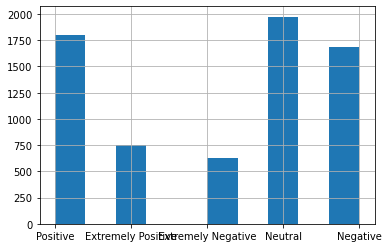

In [3]:
tweets['Sentiment'].hist()

<AxesSubplot:>

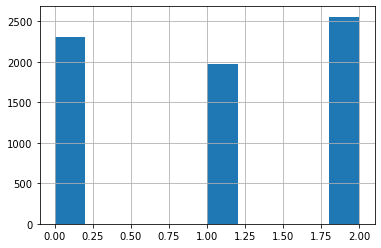

In [4]:
tweets['label'].hist()

<AxesSubplot:>

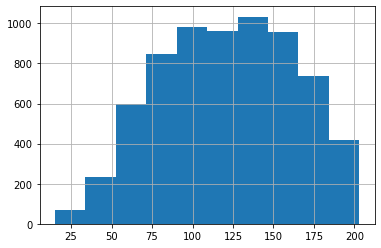

In [5]:
tweets['text'].apply(len).hist()

<AxesSubplot:title={'center':'Rolling 4 day sentiment'}, xlabel='date'>

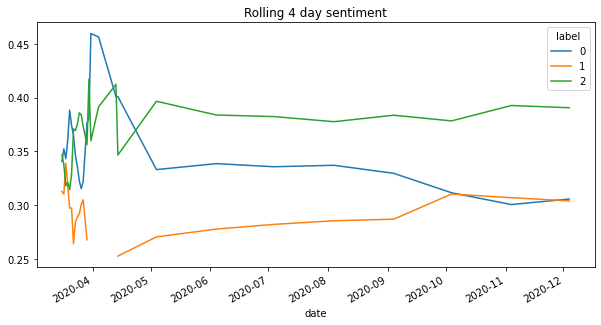

In [6]:
tweets.groupby('date')['label'].value_counts(normalize=True).unstack().rolling(4).mean().plot(
    figsize=(10, 5), title='Rolling 4 day sentiment'
)  # VERY negative at first

## Grab tweets up until the end of March

In [7]:
training_tweets = tweets[:'2020-03'].reset_index()
training_tweets.tail()


,date,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,month,text,label
2152,2020-03-31,29063,74015,"Toronto, Canada",31-03-2020,Saputo says demand for its products is shiftin...,Negative,3,Saputo says demand for its products is shiftin...,0
2153,2020-03-31,28994,73946,"has passport, will travel",31-03-2020,Covid 19 - milk supply under threat amid deman...,Negative,3,Covid 19 - milk supply under threat amid deman...,0
2154,2020-03-31,29204,74156,"Walhalla, South Carolina",31-03-2020,Our latest details how fraudsters are trying t...,Negative,3,Our latest details how fraudsters are trying t...,0
2155,2020-03-31,29187,74139,"Arlington, VA",31-03-2020,Some consumer companies tap nearly 99B amid bo...,Neutral,3,Some consumer companies tap nearly 99B amid bo...,1
2156,2020-03-31,29276,74228,"Geneva, Switzerland",31-03-2020,EuropeÃÂs fresh food supply is being threate...,Negative,3,EuropeÃÂs fresh food supply is being threate...,0


In [8]:
tweet_dataset = Dataset.from_pandas(training_tweets[['text', 'label']])

# Dataset has a built in train test split method
tweet_dataset = tweet_dataset.train_test_split(test_size=0.2)

BERT_MODEL = 'distilbert-base-uncased'
bert_tokenizer = DistilBertTokenizer.from_pretrained(BERT_MODEL)

# We will pad our dataset so that our input matrices are the same length and truncate
def preprocess(data):
    return bert_tokenizer(data['text'], truncation=True, max_length=128)

tweet_dataset = tweet_dataset.map(preprocess, batched=True, batch_size=len(tweet_dataset))

Parameter 'function'=<function preprocess at 0x7f8dc998a790> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/863 [00:00<?, ?ba/s]

  0%|          | 0/216 [00:00<?, ?ba/s]

In [9]:
train_set = tweet_dataset['train']
test_set = tweet_dataset['test']

In [10]:
sequence_classification_model = DistilBertForSequenceClassification.from_pretrained(BERT_MODEL, num_labels=3)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier

In [11]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [12]:
len(train_set)

1725

## Train a model on Tweets until the end of March

In [13]:
data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer)

In [14]:
batch_size = 32
epochs = 2

training_args = TrainingArguments(
    output_dir='./drift_clf/results',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    logging_dir='./drift_clf/logs',
    logging_strategy='epoch',
    save_strategy='epoch',
    evaluation_strategy='epoch',
    load_best_model_at_end=True
)

# Define the trainer
trainer = Trainer(
    model=sequence_classification_model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=test_set,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

In [15]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 432
  Batch size = 32


{'eval_loss': 1.0952173471450806,
 'eval_accuracy': 0.3680555555555556,
 'eval_runtime': 47.859,
 'eval_samples_per_second': 9.027,
 'eval_steps_per_second': 0.293}

## Train our DistilBERT model on tweets up until the end of March

In [16]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/Users/sinanozdemir/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1725
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 108


Epoch,Training Loss,Validation Loss,Accuracy
1,0.988500,0.809219,0.666667
2,0.669000,0.725272,0.715278


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 432
  Batch size = 32
Saving model checkpoint to ./drift_clf/results/checkpoint-54
Configuration saved in ./drift_clf/results/checkpoint-54/config.json
Model weights saved in ./drift_clf/results/checkpoint-54/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 432
  Batch size = 32
Saving model checkpoint to ./drift_clf/results/checkpoint-108
Configuration saved in ./drift_clf/results/checkpoint

TrainOutput(global_step=108, training_loss=0.8287769246984411, metrics={'train_runtime': 1284.3718, 'train_samples_per_second': 2.686, 'train_steps_per_second': 0.084, 'total_flos': 43530546646494.0, 'train_loss': 0.8287769246984411, 'epoch': 2.0})

In [17]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 432
  Batch size = 32


{'eval_loss': 0.7252721190452576,
 'eval_accuracy': 0.7152777777777778,
 'eval_runtime': 43.5068,
 'eval_samples_per_second': 9.929,
 'eval_steps_per_second': 0.322,
 'epoch': 2.0}

In [18]:
# save our best model
trainer.save_model()

Saving model checkpoint to ./drift_clf/results
Configuration saved in ./drift_clf/results/config.json
Model weights saved in ./drift_clf/results/pytorch_model.bin


## Load up our fine-tuned model (in the future)

In [19]:
# Load our model from our training directory
sequence_classification_model = DistilBertForSequenceClassification.from_pretrained(
    './drift_clf/results', num_labels=3
)


loading configuration file ./drift_clf/results/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.19.4",
  "vocab_size": 30522
}

loading weights file ./drift_clf/results/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClas

# Predict all tweets from April 1 onwards using the model only trained up until March

In [20]:
april_onwards = tweets.loc['2020-4':].reset_index()

april_onwards = Dataset.from_pandas(april_onwards[['text', 'label']])

april_onwards = april_onwards.map(preprocess, batched=True, batch_size=len(april_onwards))

tweets['predicted_label'] = None
tweets.loc['2020-4':, 'predicted_label'] = trainer.predict(april_onwards).predictions.argmax(1)

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 4685
  Batch size = 32


In [21]:
tweets.tail(2)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,month,text,label,predicted_label
date,,,,,,,,,,
2020-12-04,42574,87526,Berlin,12-04-2020,Confronting shows how far a infected person s...,Positive,12,Confronting shows how far a infected person s ...,2,0
2020-12-04,42989,87941,"Boston, MA",12-04-2020,Via @Forrester Navigate To The New Norm: Insig...,Neutral,12,Via Navigate To The New Norm: Insights From F...,1,1


In [22]:
tweets['correct_label'] = tweets['predicted_label'] == tweets['label']

tweets['2020-4':].groupby('month')['correct_label'].mean()

month
4     0.732651
5     0.713918
6     0.698517
7     0.690252
8     0.741791
9     0.728516
10    0.686170
11    0.723724
12    0.704225
Name: correct_label, dtype: float64

<AxesSubplot:xlabel='month'>

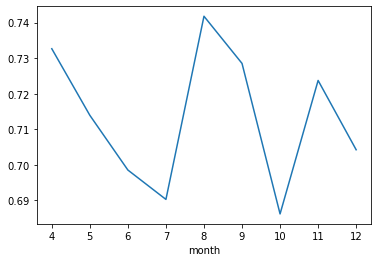

In [23]:
tweets['2020-4':].groupby('month')['correct_label'].mean().plot()

## Online Learning

In [24]:
training_tweets = tweets['2020-04']

tweet_dataset = Dataset.from_pandas(training_tweets.reset_index()[['text', 'label']])
tweet_dataset = tweet_dataset.map(preprocess, batched=True, batch_size=len(tweet_dataset))
tweet_dataset = tweet_dataset.train_test_split(test_size=0.2)

# Update the training arguments and trainer arguments

training_args = TrainingArguments(
    output_dir='./drift_clf/results',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    logging_dir='./drift_clf/logs',
    logging_strategy='epoch',
    save_strategy='epoch',
    evaluation_strategy='epoch',
    load_best_model_at_end=True
)

# Define the trainer
trainer = Trainer(
    model=sequence_classification_model,
    args=training_args,
    train_dataset=tweet_dataset['train'],
    eval_dataset=tweet_dataset['test'],
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_23124/1028072447.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  training_tweets = tweets['2020-04']


  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [25]:
# evaluate on the new data
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 176
  Batch size = 32


{'eval_loss': 0.6022270321846008,
 'eval_accuracy': 0.7556818181818182,
 'eval_runtime': 21.6004,
 'eval_samples_per_second': 8.148,
 'eval_steps_per_second': 0.278}

## Train our DistilBERT model on tweets in April only

In [26]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/Users/sinanozdemir/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 703
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Epoch,Training Loss,Validation Loss,Accuracy
1,0.686200,0.525017,0.784091
2,0.375400,0.491109,0.818182


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 176
  Batch size = 32
Saving model checkpoint to ./drift_clf/results/checkpoint-22
Configuration saved in ./drift_clf/results/checkpoint-22/config.json
Model weights saved in ./drift_clf/results/checkpoint-22/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 176
  Batch size = 32
Saving model checkpoint to ./drift_clf/results/checkpoint-44
Configuration saved in ./drift_clf/results/checkpoint-

TrainOutput(global_step=44, training_loss=0.5307818759571422, metrics={'train_runtime': 478.5891, 'train_samples_per_second': 2.938, 'train_steps_per_second': 0.092, 'total_flos': 17544481435620.0, 'train_loss': 0.5307818759571422, 'epoch': 2.0})

In [27]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 176
  Batch size = 32


{'eval_loss': 0.4911087155342102,
 'eval_accuracy': 0.8181818181818182,
 'eval_runtime': 18.7754,
 'eval_samples_per_second': 9.374,
 'eval_steps_per_second': 0.32,
 'epoch': 2.0}

In [29]:
may_onwards = tweets.loc['2020-5':].reset_index()

may_onwards = Dataset.from_pandas(may_onwards[['text', 'label']])

may_onwards = may_onwards.map(preprocess, batched=True, batch_size=len(may_onwards))

tweets['predicted_label_trained_at_4'] = None
tweets.loc['2020-5':, 'predicted_label_trained_at_4'] = trainer.predict(may_onwards).predictions.argmax(1)

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 3806
  Batch size = 32


<AxesSubplot:xlabel='month'>

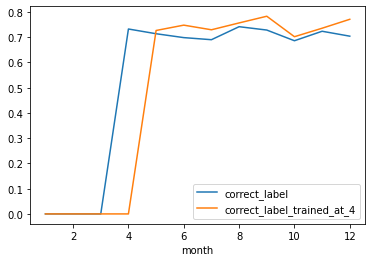

In [30]:
tweets['correct_label_trained_at_4'] = tweets['predicted_label_trained_at_4'] == tweets['label']

tweets.groupby('month')[['correct_label', 'correct_label_trained_at_4']].mean().plot()

In [31]:
training_tweets = tweets['2020-05']

tweet_dataset = Dataset.from_pandas(training_tweets.reset_index()[['text', 'label']])
tweet_dataset = tweet_dataset.map(preprocess, batched=True, batch_size=len(tweet_dataset))
tweet_dataset = tweet_dataset.train_test_split(test_size=0.2)

# Update the training arguments and trainer arguments

training_args = TrainingArguments(
    output_dir='./drift_clf/results',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    logging_dir='./drift_clf/logs',
    logging_strategy='epoch',
    save_strategy='epoch',
    evaluation_strategy='epoch',
    load_best_model_at_end=True
)

# Define the trainer
trainer = Trainer(
    model=sequence_classification_model,
    args=training_args,
    train_dataset=tweet_dataset['train'],
    eval_dataset=tweet_dataset['test'],
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_23124/3232507915.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  training_tweets = tweets['2020-05']


  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [32]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 78
  Batch size = 32


{'eval_loss': 0.648156464099884,
 'eval_accuracy': 0.7307692307692307,
 'eval_runtime': 12.8755,
 'eval_samples_per_second': 6.058,
 'eval_steps_per_second': 0.233}

## Train our DistilBERT model on tweets in May only

In [33]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/Users/sinanozdemir/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 310
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 20


Epoch,Training Loss,Validation Loss,Accuracy
1,0.750300,0.614549,0.756410
2,0.436800,0.616699,0.743590


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 78
  Batch size = 32
Saving model checkpoint to ./drift_clf/results/checkpoint-10
Configuration saved in ./drift_clf/results/checkpoint-10/config.json
Model weights saved in ./drift_clf/results/checkpoint-10/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 78
  Batch size = 32
Saving model checkpoint to ./drift_clf/results/checkpoint-20
Configuration saved in ./drift_clf/results/checkpoint-20

TrainOutput(global_step=20, training_loss=0.5935535907745362, metrics={'train_runtime': 223.7016, 'train_samples_per_second': 2.772, 'train_steps_per_second': 0.089, 'total_flos': 7469535157740.0, 'train_loss': 0.5935535907745362, 'epoch': 2.0})

In [34]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 78
  Batch size = 32


{'eval_loss': 0.6145486235618591,
 'eval_accuracy': 0.7564102564102564,
 'eval_runtime': 9.3078,
 'eval_samples_per_second': 8.38,
 'eval_steps_per_second': 0.322,
 'epoch': 2.0}

In [35]:
june_onwards = tweets.loc['2020-6':].reset_index()

june_onwards = Dataset.from_pandas(june_onwards[['text', 'label']])

june_onwards = june_onwards.map(preprocess, batched=True, batch_size=len(june_onwards))

tweets['predicted_label_trained_at_5'] = None
tweets.loc['2020-6':, 'predicted_label_trained_at_5'] = trainer.predict(june_onwards).predictions.argmax(1)

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 3418
  Batch size = 32


<AxesSubplot:xlabel='month'>

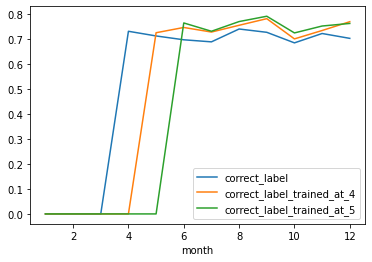

In [36]:
# Online training will generally only close minor gaps in performance and usually is not enough
tweets['correct_label_trained_at_5'] = tweets['predicted_label_trained_at_5'] == tweets['label']
tweets.groupby('month')[['correct_label', 'correct_label_trained_at_4', 'correct_label_trained_at_5']].mean().plot()

**Kullback–Leibler (KL) divergence** is a measure of difference between two probability distributions. It is unbounded and assymetric (top is continuous, bottom is discrete)
![title](../images/kl1.png)
![title](../images/kl2.png)

**Jensen-Shannon (or JS) divergence** is another way to test differences between distributions based on the KL divergence. It symmetric and it always has a finite value.
![title](../images/js.png)


In [37]:
def kl_divergence(p, q):
    '''Kullback–Leibler (KL) divergence'''
    p /= p.mean()
    q /= q.mean()
    return np.sum(p*np.log((p/(q+ 1e-5)) + 1e-5))


def js_divergence(p, q):
    '''Jensen-Shannon (or JS) divergence'''
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

## KL Divergence

In [39]:
# Calculate accuracy change by month
monthly_stats = tweets.groupby('month').agg(accuracy=('correct_label', 'mean'))
monthly_stats['accuracy_change'] = (monthly_stats['accuracy'] - monthly_stats['accuracy'][4]) / monthly_stats['accuracy'][4]
monthly_stats


,accuracy,accuracy_change
month,,
1,0.000000,-1.000000
2,0.000000,-1.000000
3,0.000000,-1.000000
4,0.732651,0.000000
5,0.713918,-0.025569
6,0.698517,-0.046589
7,0.690252,-0.057871
8,0.741791,0.012476
9,0.728516,-0.005644


In [40]:
kl_change = [0, 0, 0]  # for months 1, 2, 3
js_change = [0, 0, 0]  # for months 1, 2, 3

# Calculate divergence of predicted labels between months (ie May compared to April, etc)
for month in range(4, 13):
    kl_div = kl_divergence(
        tweets[tweets.index.month==4]['predicted_label'].value_counts(normalize=True).sort_index(),
        tweets[tweets.index.month==month]['predicted_label'].value_counts(normalize=True).sort_index()
    )
    js_div = js_divergence(
        tweets[tweets.index.month==4]['predicted_label'].value_counts(normalize=True).sort_index(),
        tweets[tweets.index.month==month]['predicted_label'].value_counts(normalize=True).sort_index()
    )
    js_change.append(js_div)
    kl_change.append(kl_div)
monthly_stats['kl'] = kl_change
monthly_stats['js'] = js_change

monthly_stats

,accuracy,accuracy_change,kl,js
month,,,,
1,0.000000,-1.000000,0.000000e+00,0.000000e+00
2,0.000000,-1.000000,0.000000e+00,0.000000e+00
3,0.000000,-1.000000,0.000000e+00,0.000000e+00
4,0.732651,0.000000,3.045914e-10,3.045914e-10
5,0.713918,-0.025569,1.677785e-03,4.193807e-04
6,0.698517,-0.046589,1.084451e-02,2.715382e-03
7,0.690252,-0.057871,3.150857e-03,7.833475e-04
8,0.741791,0.012476,1.652579e-03,4.111459e-04
9,0.728516,-0.005644,1.990314e-02,4.979115e-03


<AxesSubplot:title={'center':'Plotting Divergence with Accuracy % Change'}, xlabel='month'>

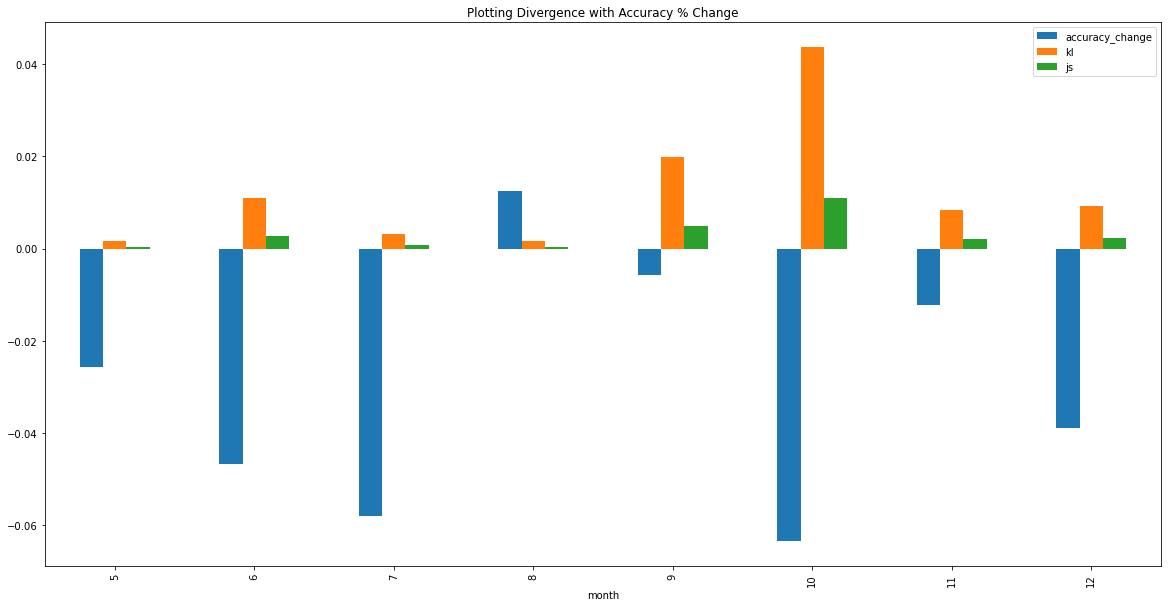

In [41]:
monthly_stats[monthly_stats.index >= 5][['accuracy_change', 'kl', 'js']].plot(
    kind='bar', figsize=(20, 10), title='Plotting Divergence with Accuracy % Change'
)

In [42]:
import torchdrift
import torch
from torch.utils.data import DataLoader
import tqdm
from nlp import Dataset
from transformers import AutoModelForSequenceClassification

In [43]:
class CovidExtractor(torch.nn.Module):
    def __init__(self):
        super(CovidExtractor, self).__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained('./drift_clf/results', num_labels=3)

    def forward(self, _input):
        return(self.model.distilbert(**_input)).last_hidden_state[:,0,:]

In [44]:
covid_extractor = CovidExtractor()

loading configuration file ./drift_clf/results/config.json
Model config DistilBertConfig {
  "_name_or_path": "./drift_clf/results",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.19.4",
  "vocab_size": 30522
}

loading weights file ./drift_clf/results/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassifi

In [45]:
# Kolmogorov-Smirnov test
detector = torchdrift.detectors.ks.KSDriftDetector()

In [46]:
training_tweets = tweets[:'2020-03'].reset_index()
training_tweets.tail()


,date,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,month,text,label,predicted_label,correct_label,predicted_label_trained_at_4,correct_label_trained_at_4,predicted_label_trained_at_5,correct_label_trained_at_5
2152,2020-03-31,29063,74015,"Toronto, Canada",31-03-2020,Saputo says demand for its products is shiftin...,Negative,3,Saputo says demand for its products is shiftin...,0,None,False,None,False,None,False
2153,2020-03-31,28994,73946,"has passport, will travel",31-03-2020,Covid 19 - milk supply under threat amid deman...,Negative,3,Covid 19 - milk supply under threat amid deman...,0,None,False,None,False,None,False
2154,2020-03-31,29204,74156,"Walhalla, South Carolina",31-03-2020,Our latest details how fraudsters are trying t...,Negative,3,Our latest details how fraudsters are trying t...,0,None,False,None,False,None,False
2155,2020-03-31,29187,74139,"Arlington, VA",31-03-2020,Some consumer companies tap nearly 99B amid bo...,Neutral,3,Some consumer companies tap nearly 99B amid bo...,1,None,False,None,False,None,False
2156,2020-03-31,29276,74228,"Geneva, Switzerland",31-03-2020,EuropeÃÂs fresh food supply is being threate...,Negative,3,EuropeÃÂs fresh food supply is being threate...,0,None,False,None,False,None,False


In [47]:
march = Dataset.from_pandas(training_tweets[['text', 'label']])

march = march.map(preprocess, batched=True)

march.set_format('torch', columns=['input_ids', 'attention_mask'])

dl = DataLoader(march, batch_size=128, collate_fn=DataCollatorWithPadding(bert_tokenizer), shuffle=True)

nb = len(dl)

  0%|          | 0/3 [00:00<?, ?it/s]

In [48]:
all_outputs = []

for i, b in tqdm.tqdm(zip(range(nb), dl), total=nb):
    with torch.no_grad():
        all_outputs.append(covid_extractor(b))

all_outputs = torch.cat(all_outputs, dim=0)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [04:15<00:00, 15.01s/it]


In [49]:
detector.fit(all_outputs)

tensor([[ 0.0967,  0.3668,  0.0490,  ..., -0.7100,  0.6925, -0.6095],
        [ 0.0807,  0.4463,  0.4179,  ..., -0.8748,  1.0755, -1.2889],
        [ 0.0253, -0.3636,  0.2418,  ..., -0.8138,  0.5400, -0.6641],
        ...,
        [ 0.0303,  0.1954,  0.0133,  ..., -0.9812,  0.9603, -0.9602],
        [-0.2580, -0.3643,  0.3187,  ..., -0.6984,  0.0365,  0.0066],
        [ 0.0367,  0.3772, -0.1711,  ..., -0.9511,  0.7813, -1.3735]])

In [50]:
dl = DataLoader(march, batch_size=512, collate_fn=DataCollatorWithPadding(bert_tokenizer), shuffle=True)

In [51]:
scores, p_vals = [], []

for i, b in tqdm.tqdm(zip(range(len(dl)), dl), total=len(dl)):
    features = covid_extractor(b)
    score = detector(features)
    p_val = detector.compute_p_value(features)
    scores.append(score)
    p_vals.append(p_val)
    print(sum(scores)/(i + 1), sum(p_vals)/(i + 1))

 20%|██████████████████████████                                                                                                        | 1/5 [01:10<04:43, 70.83s/it]

tensor(0.0627) 1.0


 40%|████████████████████████████████████████████████████                                                                              | 2/5 [02:48<04:19, 86.38s/it]

tensor(0.0671) 1.0


 60%|█████████████████████████████████████████████████████████████████████████████▍                                                   | 3/5 [04:50<03:25, 102.73s/it]

tensor(0.0671) 1.0


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 4/5 [05:58<01:28, 88.91s/it]

tensor(0.0659) 1.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:11<00:00, 74.23s/it]

tensor(0.0928) 0.8606845674224146


In [61]:
def scores_for_month(month):
    ood = tweets.loc[f'2020-{month}'].reset_index()

    ood = Dataset.from_pandas(ood[['text', 'label']])

    ood = ood.map(preprocess, batched=True)

    ood.set_format('torch', columns=['input_ids', 'attention_mask'])

    ood_dl = DataLoader(ood, batch_size=512, collate_fn=DataCollatorWithPadding(bert_tokenizer), shuffle=True)
    
    ood_scores, ood_p_vals = [], []

    for i, b in tqdm.tqdm(zip(range(len(ood_dl)), ood_dl), total=len(ood_dl)):
        features = covid_extractor(b)
        score = detector(features)
        p_val = detector.compute_p_value(features)
        ood_scores.append(score)
        ood_p_vals.append(p_val)

    return sum(ood_p_vals) / len(ood_p_vals)


In [62]:
monthly_stats['ks_p_value'] = monthly_stats.index.map(scores_for_month)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:26<00:00, 26.55s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:50<00:00, 50.53s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:57<00:00, 74.50s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:55<00:00, 57.76s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:04<00:00, 64.02s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:49<00:00, 54.50s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:51<00:00, 85.74s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:43<00:00, 51.67s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:59<00:00, 59.83s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:53<00:00, 53.03s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.50s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:34<00:00, 34.25s/it]


<AxesSubplot:title={'center':'Plotting Divergence with Accuracy % Change'}, xlabel='month'>

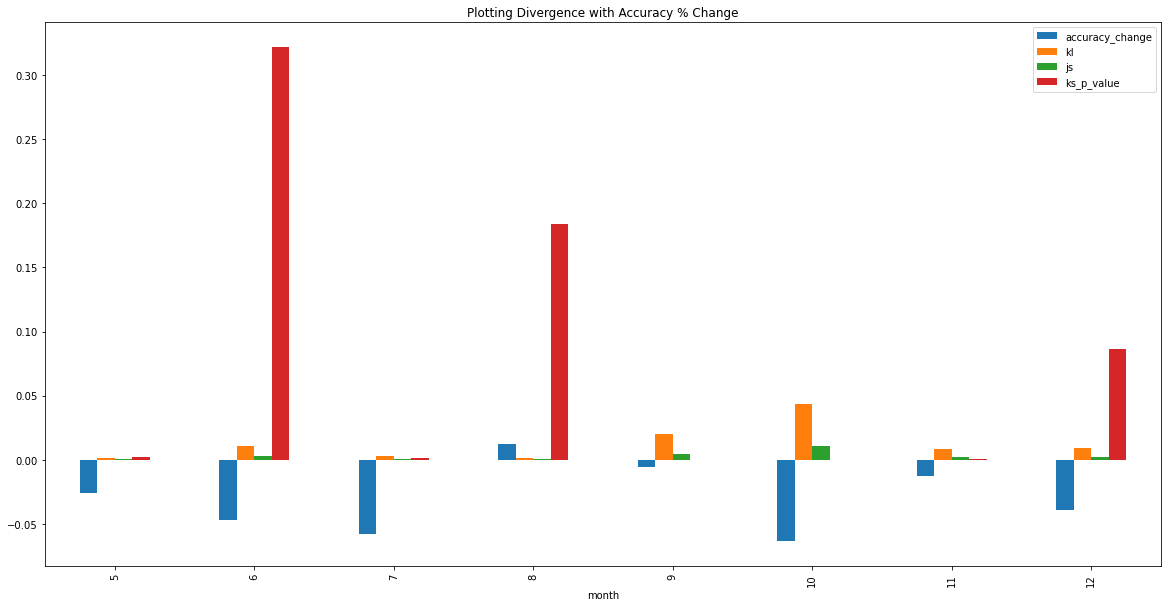

In [66]:
monthly_stats[monthly_stats.index >= 5][['accuracy_change', 'kl', 'js', 'ks_p_value']].plot(
    kind='bar', figsize=(20, 10), title='Plotting Divergence with Accuracy % Change'
)

In [70]:
monthly_stats

,accuracy,accuracy_change,kl,js,ks_p_value
month,,,,,
1,0.000000,-1.000000,0.000000e+00,0.000000e+00,9.220531e-02
2,0.000000,-1.000000,0.000000e+00,0.000000e+00,2.855609e-04
3,0.000000,-1.000000,0.000000e+00,0.000000e+00,9.960617e-01
4,0.732651,0.000000,3.045914e-10,3.045914e-10,4.764943e-04
5,0.713918,-0.025569,1.677785e-03,4.193807e-04,1.951831e-03
6,0.698517,-0.046589,1.084451e-02,2.715382e-03,3.215500e-01
7,0.690252,-0.057871,3.150857e-03,7.833475e-04,1.550135e-03
8,0.741791,0.012476,1.652579e-03,4.111459e-04,1.838562e-01
9,0.728516,-0.005644,1.990314e-02,4.979115e-03,1.399075e-05


In [75]:
monthly_stats.corrwith(monthly_stats['accuracy_change'])  # highly correlated with accuracy change

accuracy           1.000000
accuracy_change    1.000000
kl                 0.364129
js                 0.364123
ks_p_value        -0.466335
dtype: float64